## Import library yang dibutuhkan

In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import numpy as np
from numpy import concatenate
from math import sqrt

## Baca dataset

In [7]:
#target untuk di regresi: RR, menggunakan data tanggal, RH average, SS, dan T average
data = pd.read_csv('data_bmkg_clean.csv',index_col=0)
data

,Tanggal,RH_avg,Tavg,RR,ss
0,01-01-2012,25.1,87.0,39.5,2.9
1,02-01-2012,25.3,85.0,8.5,3.0
2,03-01-2012,26.4,88.0,2.0,3.1
3,04-01-2012,26.7,81.0,2.8,7.8
4,05-01-2012,26.6,85.0,8.8,5.2
...,...,...,...,...,...
3952,26-09-2022,27.4,82.0,9.3,6.0
3953,27-09-2022,27.4,82.0,34.2,3.3
3954,28-09-2022,26.9,81.0,9.9,7.3
3955,29-09-2022,25.8,79.0,2.6,3.4


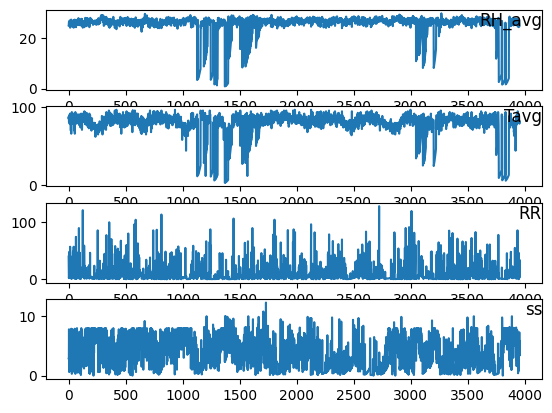

In [8]:
# load dataset
values = data.values
# specify columns to plot
groups = [ 1, 2, 3,4]
i = 1
# plot each column
plt.figure()
for group in groups:
 plt.subplot(len(groups), 1, i)
 plt.plot(values[:, group])
 plt.title(data.columns[group], y=0.7, loc='right')
 i += 1
plt.show()

In [9]:
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

## Persiapkan bentuk dataset agar lebih mudah diolah LSTM

In [57]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
 names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = pd.concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg
 
 
# load dataset
dataset = pd.read_csv('data_bmkg_clean.csv', index_col=0)
dataset = dataset.drop(["Tanggal"], axis = 1)
dataset = swap_columns(dataset, 'RR', 'ss')
values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5,6]], axis=1, inplace=True)
print(reframed.head())


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var4(t)
1   0.834483   0.894180   0.235772   0.310481  0.066194
2   0.841379   0.873016   0.243902   0.066194  0.014972
3   0.879310   0.904762   0.252032   0.014972  0.021277
4   0.889655   0.830688   0.634146   0.021277  0.068558
5   0.886207   0.873016   0.422764   0.068558  0.021277


### Simpan nilai scaler agar bisa di lakukan prediksi tanpa train ulang

In [58]:
import pickle 
object = scaler
filehandler = open('scaler.obj', 'wb') 
pickle.dump(object, filehandler)

### Cek ukuran data yang sudah di frame

In [59]:
values.shape

(3957, 4)

In [60]:
scaled.shape

(3957, 4)

In [61]:
reframed.shape

(3956, 5)

### Potong data menjadi train dan test

In [62]:
values = reframed.values
n_train_days = int(len(reframed)*0.8)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3164, 1, 4) (3164,) (792, 1, 4) (792,)


In [63]:
test_X

array([[[0.8862069 , 0.8412698 , 0.18699186, 0.02915682]],

       [[0.8724138 , 0.7248677 , 0.19512196, 0.02994484]],

       [[0.85862064, 0.77777773, 0.10569105, 0.02758077]],

       ...,

       [[0.9137931 , 0.8412698 , 0.26829267, 0.2687155 ]],

       [[0.8965517 , 0.83068776, 0.5934959 , 0.07722615]],

       [[0.85862064, 0.80952376, 0.27642277, 0.01970055]]], dtype=float32)

## Buat RNN LSTM dan Training

In [9]:
# design network

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, 
                    epochs=50, 
                    batch_size=72, 
                    validation_data=(test_X, test_y), 
                    shuffle=False)
# plot history


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-12-07 12:35:03.660057: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-07 12:35:03.660522: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2022-12-07 12:35:04.031878: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-07 12:35:04.486565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-07 12:35:04.604561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-07 12:35:04.720295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 2s 13ms/step - loss: 0.0605 - val_loss: 0.0565
Epoch 2/50
 9/44 [=====>........................] - ETA: 0s - loss: 0.0638

2022-12-07 12:35:05.605467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-07 12:35:05.648169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 0s 8ms/step - loss: 0.0547 - val_loss: 0.0558
Epoch 3/50
44/44 [==============================] - 0s 8ms/step - loss: 0.0546 - val_loss: 0.0560
Epoch 4/50
44/44 [==============================] - 0s 8ms/step - loss: 0.0545 - val_loss: 0.0560
Epoch 5/50
44/44 [==============================] - 0s 8ms/step - loss: 0.0544 - val_loss: 0.0562
Epoch 6/50
44/44 [==============================] - 0s 8ms/step - loss: 0.0544 - val_loss: 0.0562
Epoch 7/50
44/44 [==============================] - 0s 7ms/step - loss: 0.0544 - val_loss: 0.0562
Epoch 8/50
44/44 [==============================] - 0s 8ms/step - loss: 0.0543 - val_loss: 0.0562
Epoch 9/50
44/44 [==============================] - 0s 8ms/step - loss: 0.0543 - val_loss: 0.0562
Epoch 10/50
44/44 [==============================] - 0s 7ms/step - loss: 0.0543 - val_loss: 0.0563
Epoch 11/50
44/44 [==============================] - 0s 7ms/step - loss: 0.0543 - val_loss: 0.0563
Epoch 12/50
44/44 [==========

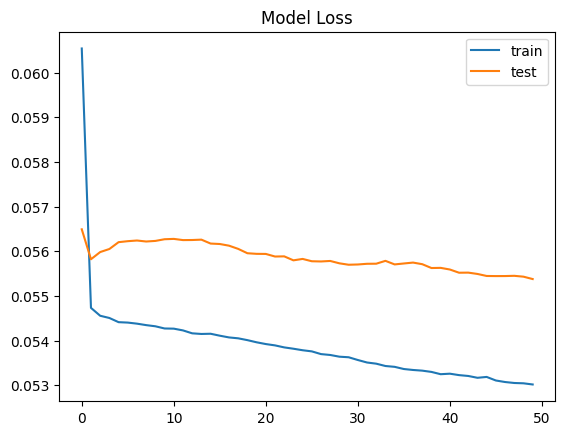

In [10]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Model Loss")
plt.legend()
plt.show()

## buat prediksi untuk pengujian

In [11]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
print(inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

25/25 [==============================] - 0s 3ms/step
(792, 4)
Test RMSE: 3.035


2022-12-07 12:35:22.446550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-07 12:35:22.486610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


## Simpan model

In [13]:
model.save('prediksi.h5')

## Load model dan prediksi

In [2]:
import pickle 
filehandler = open('scaler.obj', 'rb') 
scaler = pickle.load(filehandler)

In [3]:
model = tf.keras.models.load_model('prediksi.h5')

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-12-09 11:49:40.299521: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-09 11:49:40.300269: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11000     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________


In [9]:
# input data di sini:
RH_avg = 26.4
Tavg = 88
Ss = 3.1
RR = 2


data_prediksi = [[RH_avg,Tavg,Ss,RR]]
data_prediksi = scaler.transform(data_prediksi)
data_prediksi = np.expand_dims(data_prediksi, axis=0)

prediksi = model.predict(data_prediksi)
data_prediksi = data_prediksi.reshape((data_prediksi.shape[0], data_prediksi.shape[2]))

prediksi
hasil = concatenate((prediksi, data_prediksi[:, 1:]), axis=1)
hasil = scaler.inverse_transform(hasil)

hasil


1/1 [==============================] - 0s 18ms/step


array([[ 2.35878455, 88.        ,  3.1       ,  2.        ]])

In [10]:
# prakiraan RR untuk keesokan harinya
hasil[0][0]

2.358784548412206

In [6]:
prediksi

array([[0.05030292]], dtype=float32)

In [7]:
data_prediksi[:, 1:]

array([[0.90476188, 0.25203251, 0.01497242]])